In [130]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


In [131]:

data = pd.read_csv('AirPassengers.csv')
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

     Month  #cases
0  1949-01     112
1  1949-02     118
2  1949-03     132
3  1949-04     129
4  1949-05     121

 Data Types:
Month     object
#cases     int64
dtype: object


In [132]:
from datetime import datetime
con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [133]:

#convert to time series:
ts = data['#cases']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #cases, dtype: int64

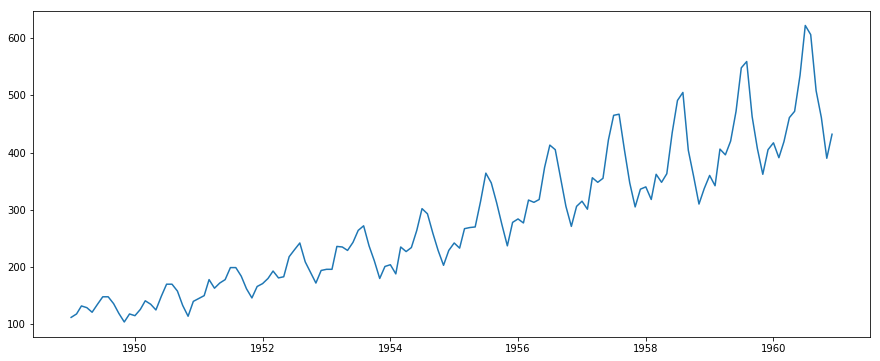

In [134]:
plt.plot(ts)

In [135]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #olmean = pd.rolling_mean(timeseries, window=12)
    ts_log = np.log(ts)
    rolmean = timeseries.rolling(window=24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


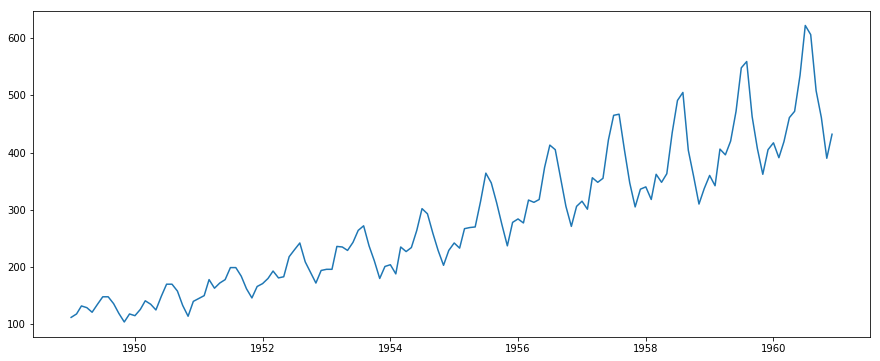

In [136]:
plt.plot(ts)

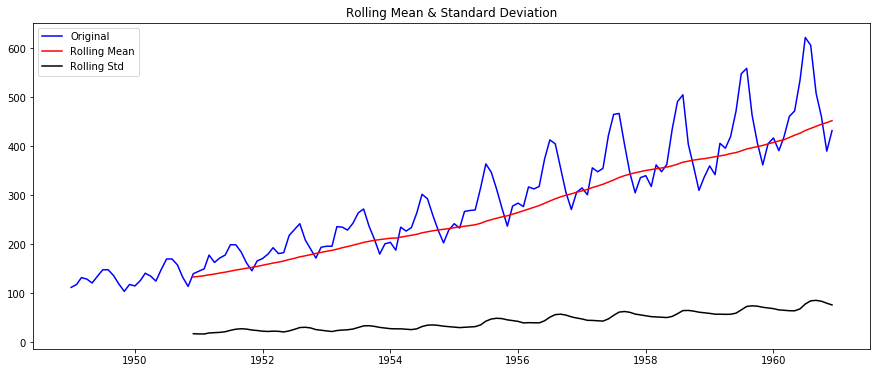

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [137]:
test_stationarity(ts)


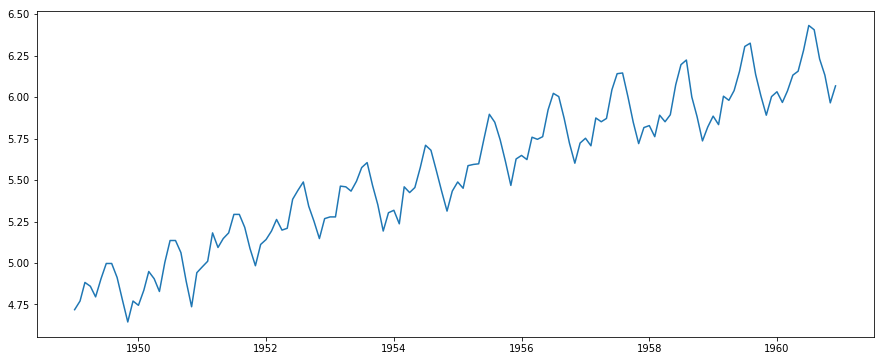

In [138]:

ts_log = np.log(ts)
plt.plot(ts_log)

In [139]:
moving_avg =rolmean.rolling(window=12,center=False).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

NameError: name 'rolmean' is not defined

In [140]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #cases, dtype: float64

In [141]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #cases, dtype: float64

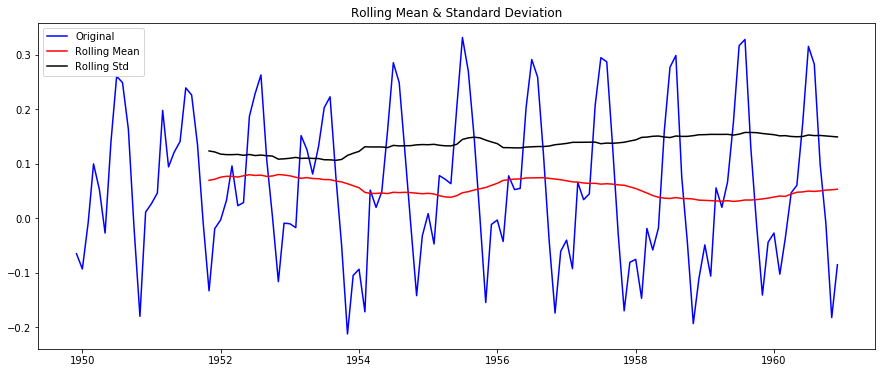

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [142]:
test_stationarity(ts_log_moving_avg_diff)

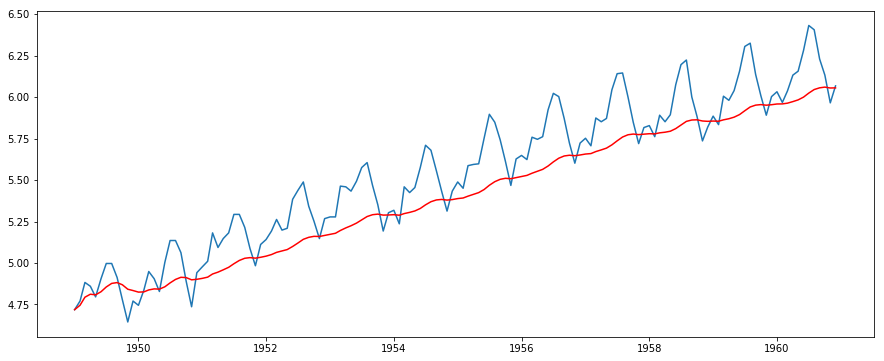

In [143]:
expwighted_avg = ts_log.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

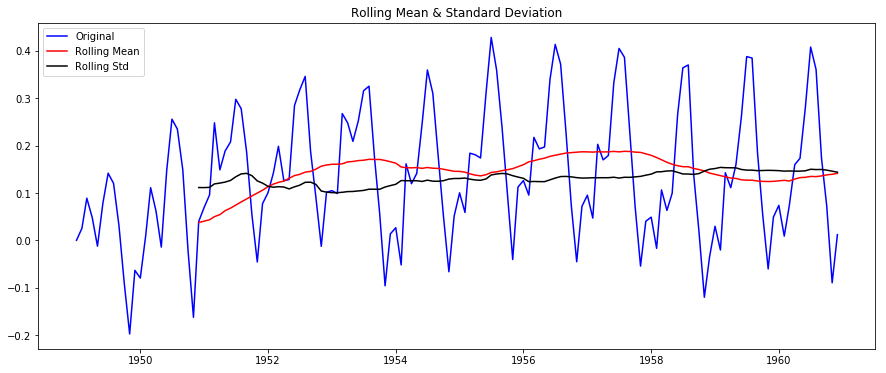

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [144]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

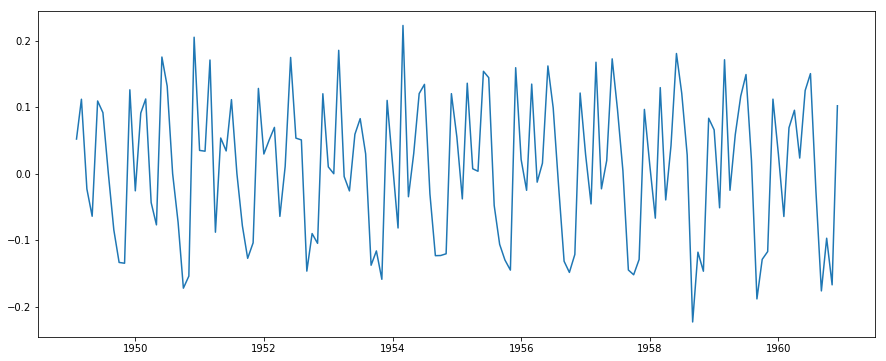

In [145]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [146]:
ts_log_diff.isnull().sum()

1

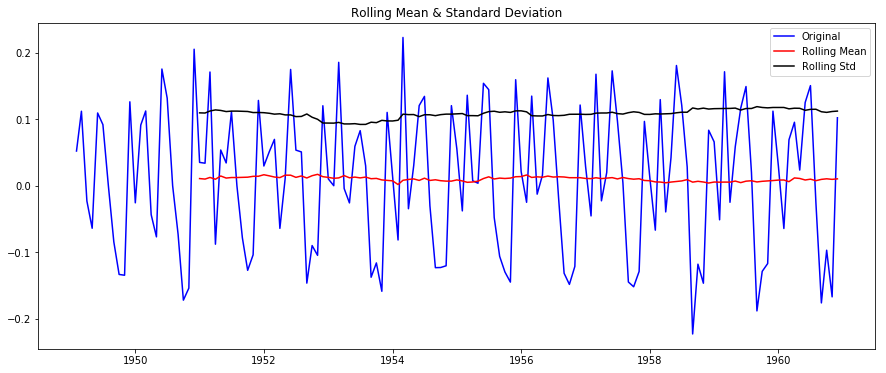

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [147]:

ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

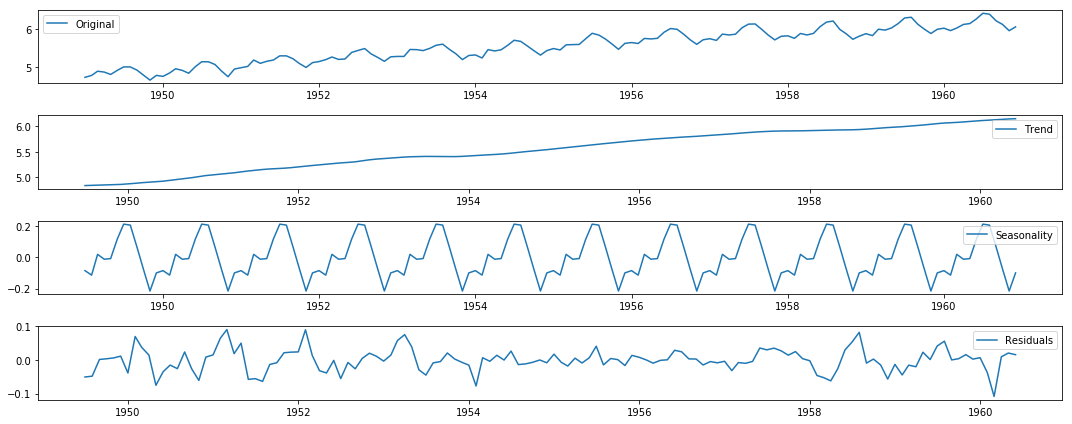

In [148]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

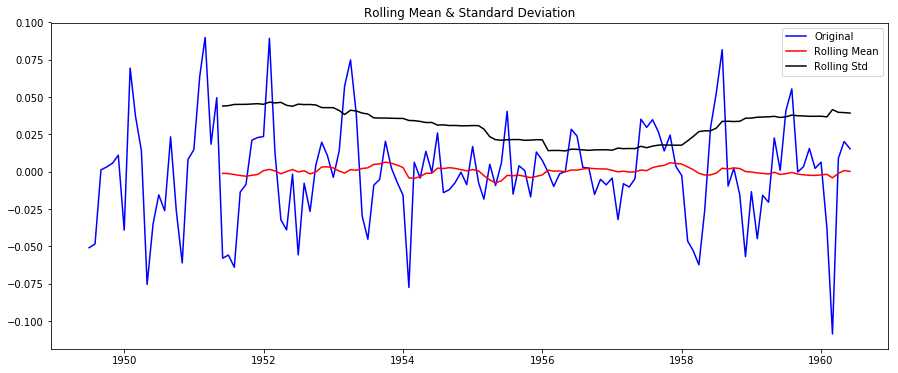

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [149]:

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

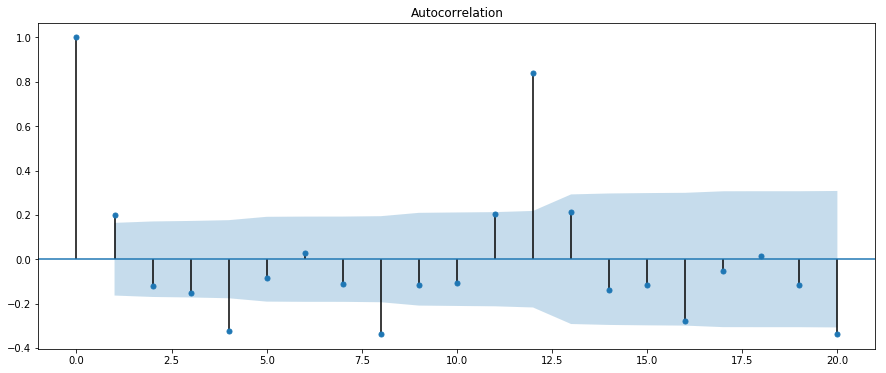

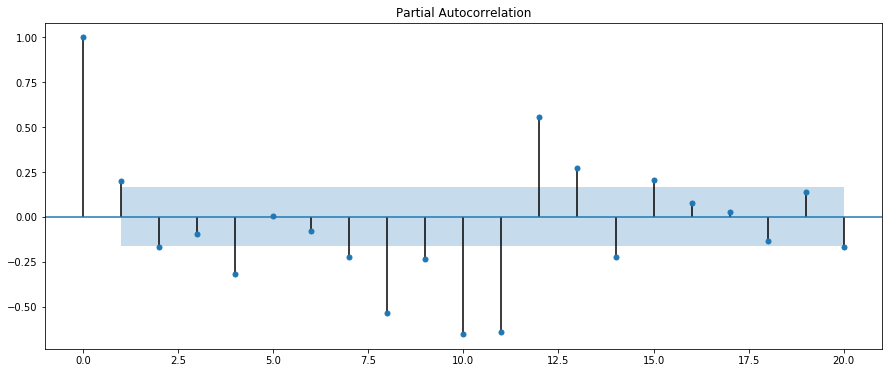

In [150]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log_diff, lags =20)
plot_pacf(ts_log_diff, lags =20)

plt.show()

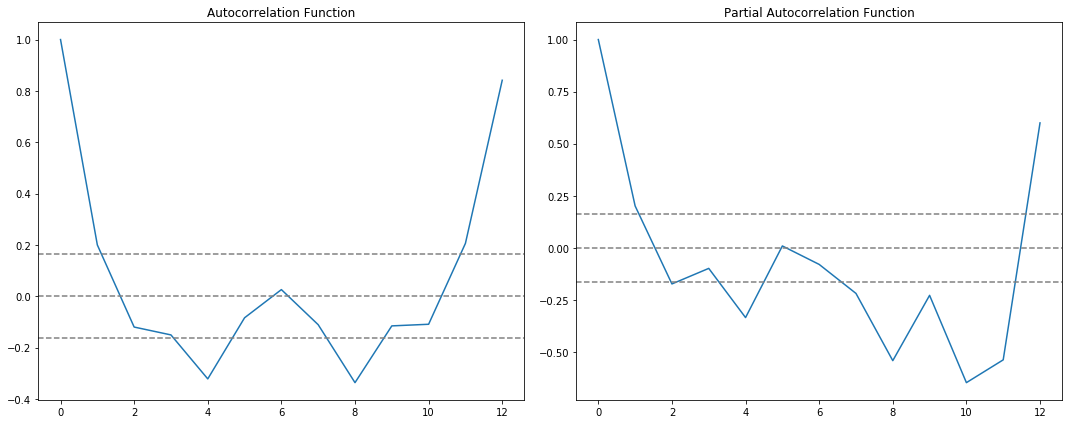

In [151]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=12)
lag_pacf = pacf(ts_log_diff, nlags=12, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS:0.0003')

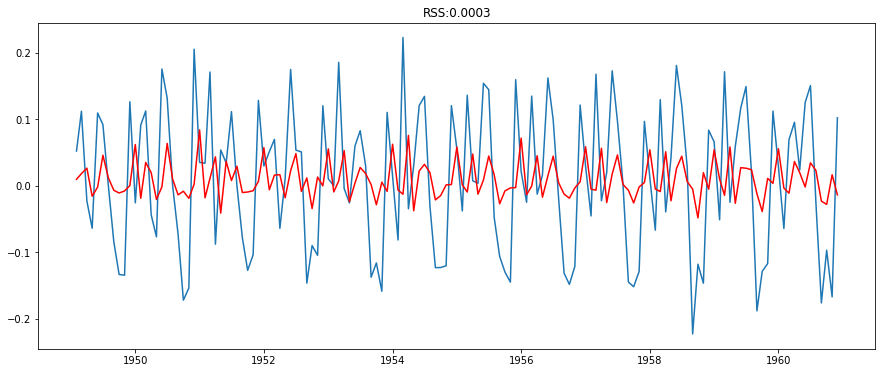

In [152]:
model=ARIMA(ts_log,order=(2 , 1, 0))
results_AR=model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum(results_AR.fittedvalues-ts_log_diff)**2)

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS:0.0003')

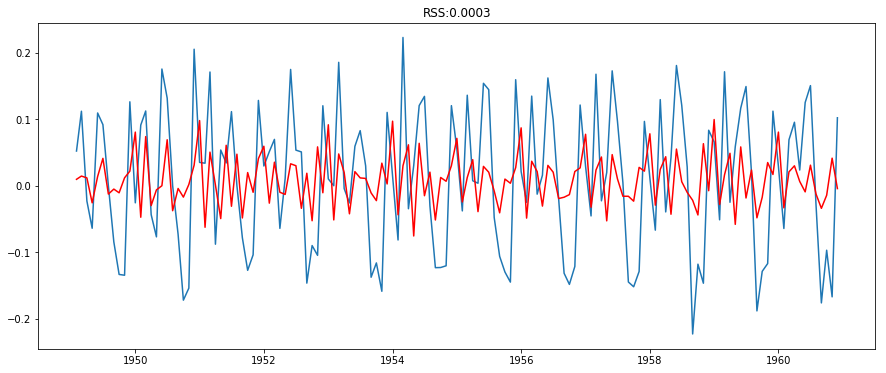

In [153]:
model=ARIMA(ts_log,order=( 0, 1, 2))
results_MA=model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum(results_AR.fittedvalues-ts_log_diff)**2)

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS:0.0003')

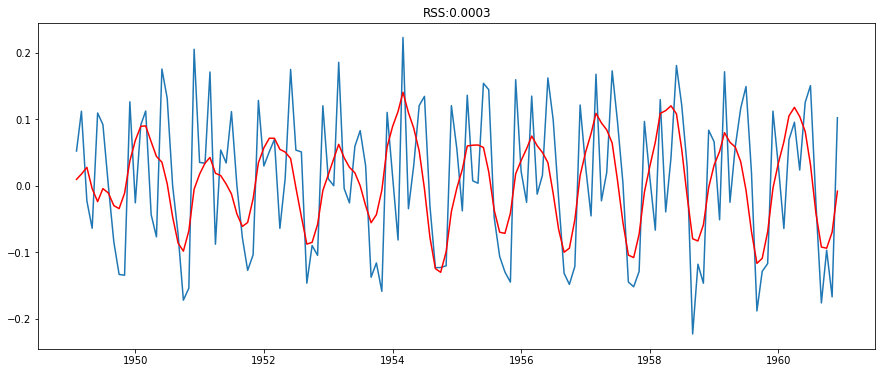

In [154]:
model=ARIMA(ts_log,order=(2 , 1, 2))
results_ARIMA=model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum(results_AR.fittedvalues-ts_log_diff)**2)

In [155]:
predictions_ARIMA_diff=pd.Series(results_ARIMA.fittedvalues,copy=True)
print (predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [156]:
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
print( predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [157]:
predictions_ARIMA_log=pd.Series(ts_log.iloc[0],index=ts_log.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE:893.353980')

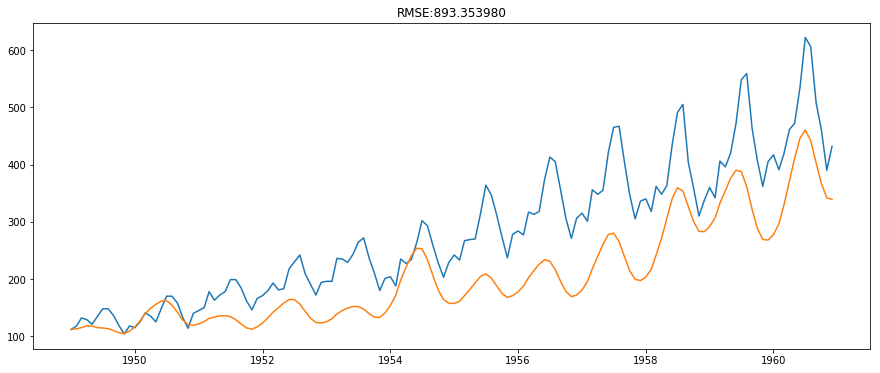

In [158]:
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE:%4f'%np.sqrt(sum(prediction_ARIMA-ts)**2/len(ts)))